In [2]:
%matplotlib inline

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import SGD,Adagrad

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import dicom

In [5]:
K.set_session(sess)

# Segmentation of ROI


In [5]:
model = Sequential()
model.add(Convolution2D(100, 11, 11, border_mode='same', input_shape=(1, 64, 64),init='glorot_normal'))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.add(Flatten())
model.add(Dense(1024,activation='sigmoid'))

#sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

# Filters Pre-training -  Sparse autoencoder

In [6]:
from keras import backend as K
from keras.regularizers import Regularizer
from keras.objectives import kld
import h5py

In [7]:
# For the Kullback-Leibler divergence regularization

class SparseActivityRegularizer(Regularizer):

    def __init__(self, l1=0., l2=0.,p = 0.05,beta = 3):
        self.l1 = K.cast_to_floatx(l1)
        self.l2 = K.cast_to_floatx(l2)
        self.uses_learning_phase = True
        self.layer = None
        self.p = p

    def set_layer(self, layer):
        if self.layer is not None:
            raise Exception('Regularizers cannot be reused')
        self.layer = layer

    def __call__(self, loss):
        if self.layer is None:
            raise Exception('Need to call `set_layer` on '
                            'ActivityRegularizer instance '
                            'before calling the instance.')
        regularized_loss = loss
        
        
        for i in range(len(self.layer.inbound_nodes)):
            output = self.layer.get_output_at(i)
            
            p_hat = K.mean(output, axis=0)
            regularized_loss += beta*K.sum(self.p * K.log(self.p / (p_hat+K.epsilon())))
            
        return K.in_train_phase(regularized_loss, loss)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'l1': float(self.l1),
                'l2': float(self.l2)}


#### First we need to generate the dataset of 11*11 patches from the images to pre-train the filters of the convolutional network

In [8]:
PATH_TRAINING = '../data/input_training.h5'
file_h5 = h5py.File(PATH_TRAINING,'r')
n = file_h5['X'].shape[0]
PATH_TRAINING = '../data/input_training.h5'
nb_epoch = 50
N1 = int(1e4)

In [9]:
# Random sequences for random patches
seq = np.random.randint(n,size = (int(N1)))
i_idx = np.random.randint(64-11,size = (int(N1)))
j_idx = np.random.randint(64-11,size = (int(N1)))

In [10]:
def generate_patch_from_h5(path,seq,i_seq,j_seq,patch_size = 11,N1 = int(1e4)):
    '''
    Generates patches of size 11*11 to feed to the sparse auto-encoder
    '''
    
    while 1:
        file_h5 = h5py.File(path,'r')
        n = file_h5['X'].shape[0]

        for k in range(int(N1)):

            img = file_h5['X'][seq[k]]
            i = i_seq[k]
            j = j_seq[k]

            patch = img[i:i+11,j:j+11]
            patch = patch.flatten().reshape(1,121)

            yield (patch,patch)

        file_h5.close()
    

In [11]:
lambd = 1e-4
rho = 0.1
beta = 3

activity_regularizer = SparseActivityRegularizer(p=rho,beta=beta)

autoencoder = Sequential()
# Hidden layer, the bias is included by default
autoencoder.add(Dense(100,input_dim=121,activation='sigmoid',W_regularizer=l2(lambd/2),activity_regularizer=activity_regularizer))
autoencoder.add(Dense(121,activation='sigmoid',W_regularizer=l2(lambd/2)))
autoencoder.summary()

sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
#ada = Adagrad()
autoencoder.compile(loss='mean_squared_error', optimizer=sgd)
                         
history = autoencoder.fit_generator(generate_patch_from_h5(PATH_TRAINING,seq,i_idx,j_idx),samples_per_epoch=N1, nb_epoch=1,nb_worker=4)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 100)           12200       dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 121)           12221       dense_1[0][0]                    
Total params: 24421
____________________________________________________________________________________________________
Epoch 1/1
10000/10000 [==============================] - 73s - loss: 1752.8016    


/Users/Thomas/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The "nb_worker" argument is deprecated when pickle_safe is False
  warnings.warn('The "nb_worker" argument is deprecated when pickle_safe is False')


In [14]:
PATH_FILTERS = '../data/weights/filters_1.h5'

In [160]:
autoencoder.save_weights(PATH_FILTERS)

## This allows to plot the filters

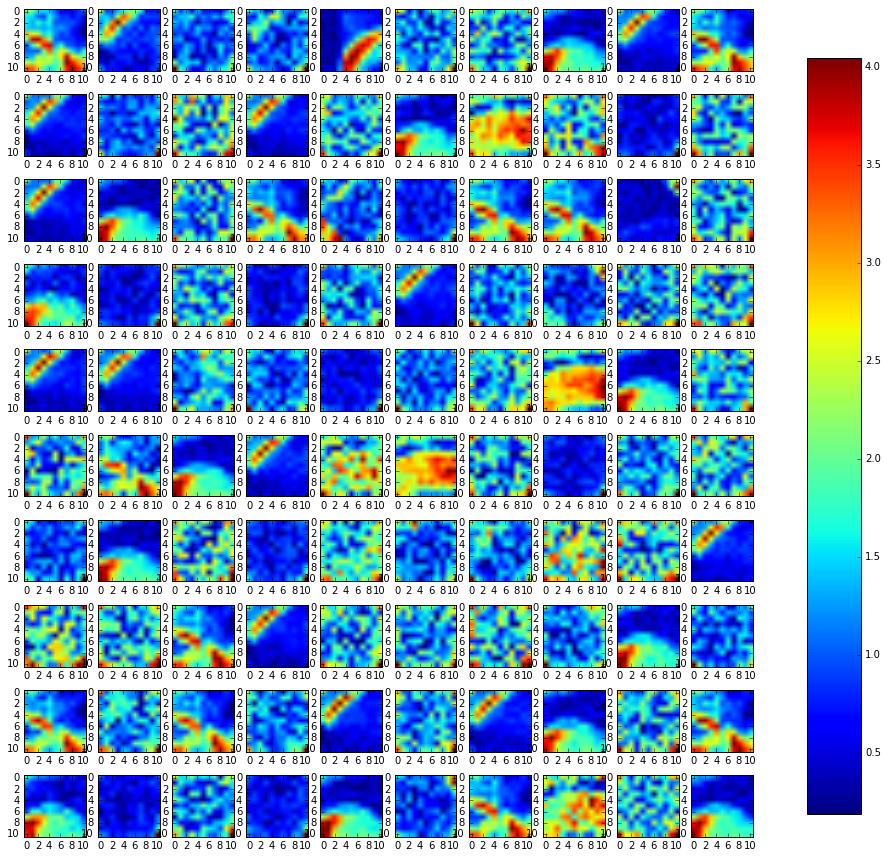

In [12]:

fig, axes = plt.subplots(nrows=10, ncols=10)
for k,ax in enumerate(axes.flat):
    im = ax.imshow(autoencoder.layers[0].get_weights()[0][:,k].reshape(11,11))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

# This plots the evolution of the loss

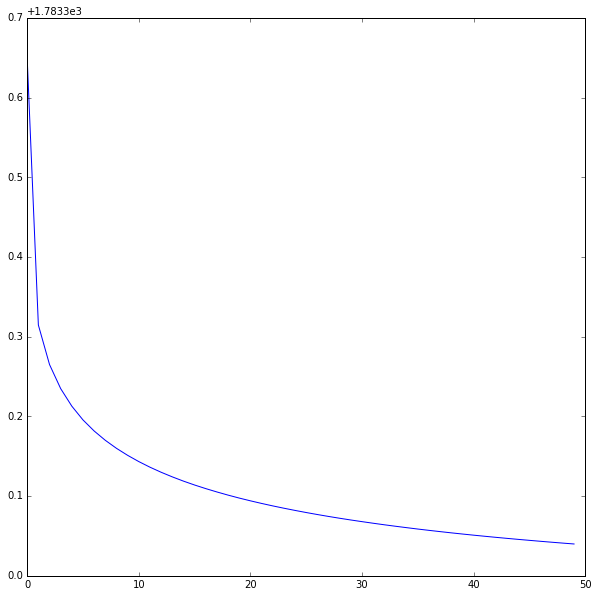

In [103]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])

### Generation of the MaxPooled activations for input in order to pre-train the output layer

In [160]:
def generate_image_from_h5(path):
    '''
    Generates patches of size 11*11 to feed to the sparse auto-encoder
    '''
    
    while 1:
        file_h5 = h5py.File(path,'r')
        n = file_h5['X'].shape[0]

        for k in range(int(N1)):
            img = file_h5['X'][k]
            yield (img)

        file_h5.close()
    

In [161]:
generate_image_from_h5(PATH_TRAINING)

In [15]:
file = h5py.File(PATH_FILTERS, 'r')  

filters = file['dense_18']['dense_18_W:0']
weights_filters = []
for k in range(100):
    weights_filters.append(filters[:,k].reshape(11,11))

weights_filters = np.array(weights_filters).reshape(100,1,11,11)
b = file['dense_18']['dense_18_b:0']

KeyError: "Unable to open object (Object 'dense_18' doesn't exist)"

In [16]:
filters = file['dense_6']['dense_6_W:0']
weights_filters = []
for k in range(100):
    weights_filters.append(filters[:,k].reshape(11,11))

weights_filters = np.array(weights_filters).reshape(100,1,11,11)
b = file['dense_6']['dense_6_b:0']

In [17]:
model = Sequential()
model.add(Convolution2D(100, 11, 11, border_mode='valid', input_shape=(1, 64, 64),weights= [weights_filters,b]))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 100, 54, 54)   12200       convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 100, 9, 9)     0           convolution2d_1[0][0]            
Total params: 12200
____________________________________________________________________________________________________


In [251]:
file_h5 = h5py.File(PATH_TRAINING,'r')
n = file_h5['X'].shape[0]

Computes activation after maxpool

In [18]:
OUTPUT = '../data/roi_activations_after_maxpool.h5'

In [19]:
with h5py.File(OUTPUT, 'w') as hf:
    X = hf.create_dataset("X", (n, 100 ,9, 9), maxshape=(None, 100 ,9, 9))
    
    for k in range(n):
        
        prediction = model.predict(file_h5['X'][k].reshape(1,1,64,64))
        X[k,:,:,:] = prediction

In [22]:
img_nb = 1
img = file_h5['X'][img_nb]

In [23]:
file_h5_out = h5py.File(OUTPUT,'r')

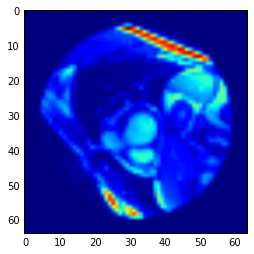

In [24]:
plt.imshow(img)

### Plot activations

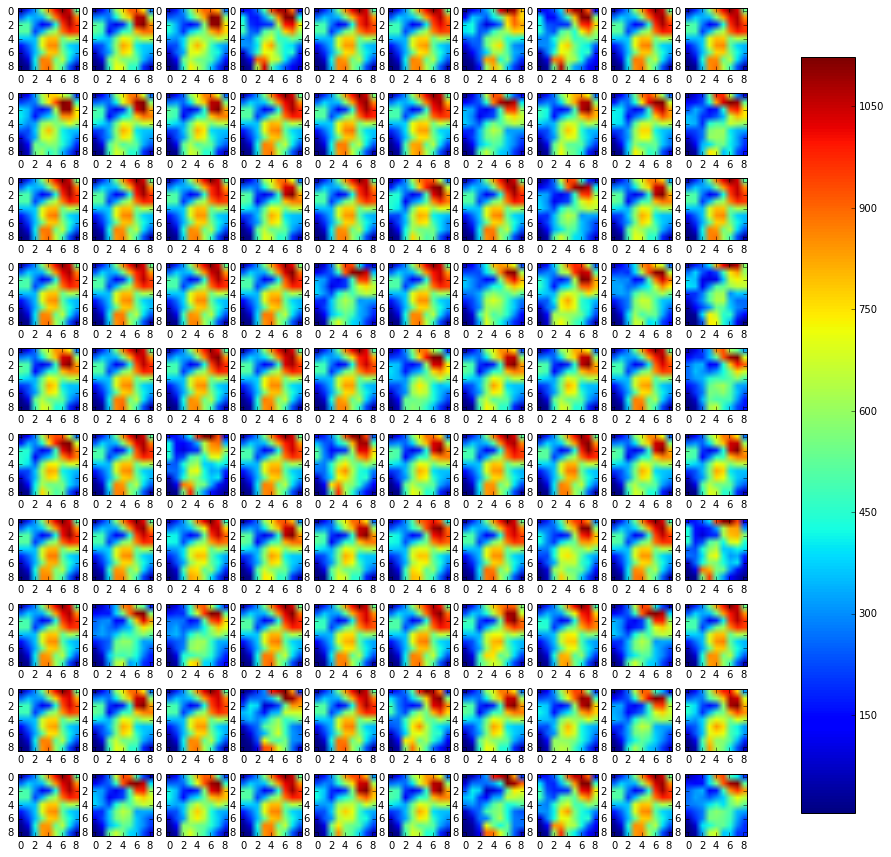

In [25]:
fig, axes = plt.subplots(nrows=10, ncols=10)
for k,ax in enumerate(axes.flat):
    im = ax.imshow(file_h5_out['X'][img_nb][k])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

# Output pre-training

In [169]:
def generate_maxpooled_activations_from_h5(path):
    '''
    Generates patches of size 11*11 to feed to the sparse auto-encoder
    '''
    
    while 1:
        
        activations_h5 = h5py.File(path,'r')
        n = activations_h5['X'].shape[0]
        
        roi_h5 = h5py.File('../data/roi_training_sub.h5','r')

        for k in range(260):
            img = activations_h5['X'][k]
            img = img.reshape((1,100,9,9))
            roi = roi_h5['X'][k]
            roi = roi.flatten().reshape((1,1024))
            yield (img,roi)

    file_h5.close()
    

In [170]:
a = generate_maxpooled_activations_from_h5(OUTPUT)
v = next(a)

In [171]:
print(v[0].shape,v[1].shape)

(1, 100, 9, 9) (1, 1024)


In [172]:
lamd = 1e-4
# The input will be the MaxPooled activations of size (100,9,9)
pretrain = Sequential()
pretrain.add(Flatten(input_shape = (100,9,9)))
pretrain.add(Dense(1024,activation='sigmoid',W_regularizer=l2(lamd)))
pretrain.summary()


ada = Adagrad()
pretrain.compile(loss='mean_squared_error', optimizer=ada)
                         
history = pretrain.fit_generator(generate_maxpooled_activations_from_h5(OUTPUT),samples_per_epoch=260, nb_epoch=nb_epoch)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_5 (Flatten)              (None, 8100)          0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 1024)          8295424     flatten_5[0][0]                  
Total params: 8295424
____________________________________________________________________________________________________
Epoch 1/50
260/260 [==============================] - 148s - loss: 0.1894   
Epoch 2/50
260/260 [==============================] - 147s - loss: 0.1918   
Epoch 3/50
260/260 [==============================] - 141s - loss: 0.1906   
Epoch 4/50
260/260 [==============================] - 174s - loss: 0.1861   
Epoch 5/50
260/260 [==============================] - 175s - los

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

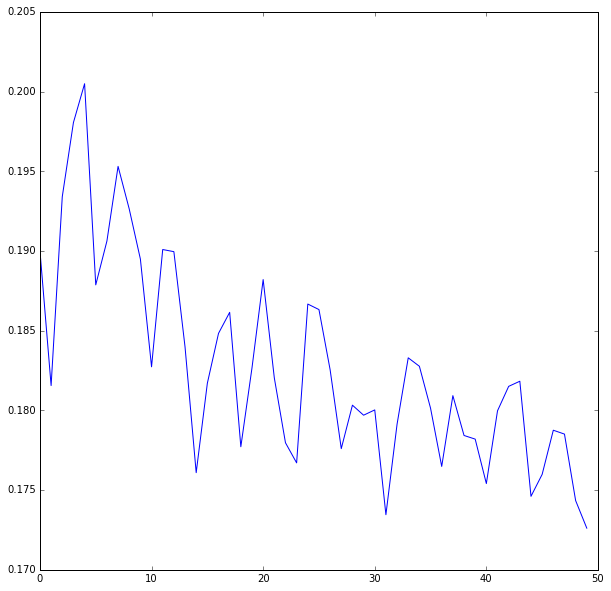

In [316]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])

In [14]:
FC_WEIGHTS = '../data/weights/roi_final_layer.h5'

In [321]:
pretrain.save_weights(FC_WEIGHTS)

# Segmentation of ROI


In [30]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
def generate_end2end_from_h5():


    while 1:
        
        activations_h5 = h5py.File(PATH_TRAINING,'r')
        n = activations_h5['X'].shape[0]
        
        roi_h5 = h5py.File('../data/roi_training_sub.h5','r')

        for k in range(260):
            img = activations_h5['X'][k]
            img = img.reshape((1,1,64,64))
            roi = roi_h5['X'][k]
            roi = roi.flatten().reshape((1,1024))
            yield (img,roi)

    file_h5.close()
    

In [19]:
def generate_end2end_from_h5_1():


    while 1:
        
        activations_h5 = h5py.File(PATH_TRAINING,'r')
        n = activations_h5['X'].shape[0]
        
        roi_h5 = h5py.File('../data/roi_training_sub.h5','r')

        for k in range(260):
            img = activations_h5['X'][k]
            img = img.reshape((1,1,64,64))
            roi = roi_h5['X'][k]
            #roi = roi.flatten().reshape((1,1024))
            yield (img,roi)

    file_h5.close()
    

In [20]:
X = []
y = []

In [21]:
gen = generate_end2end_from_h5_1()

In [22]:
for k in range(260):
    u = next(gen)
    input_ = u[0]
    label = u[1]
    X.append(input_)
    y.append(label)

In [23]:
X_train = np.array(X)
y = np.array(y)

In [24]:
y.shape

(260, 32, 32)

In [25]:
X_train = X_train.reshape(X_train.shape[0], 1, 64, 64)
y = y.reshape(y.shape[0], 1, 32, 32)

In [65]:
datagen = ImageDataGenerator()

In [66]:
datagen.fit(X_train)

### Load convolutional filters

In [162]:
file = h5py.File(PATH_FILTERS, 'r')  


In [165]:
file = h5py.File(PATH_FILTERS, 'r')  

filters = file['dense_6']['dense_6_W:0']
weights_filters = []
for k in range(100):
    weights_filters.append(filters[:,k].reshape(11,11))

weights_filters = np.array(weights_filters).reshape(100,1,11,11)
b = file['dense_6']['dense_6_b:0']

### Load fc weights

In [166]:
file = h5py.File(FC_WEIGHTS, 'r')  

weights_fc = file['dense_26']['dense_26_W:0']
bias_fc = file['dense_26']['dense_26_b:0']

In [167]:
model = Sequential()
model.add(Convolution2D(100, 11, 11, border_mode='valid', input_shape=(1, 64, 64),init='glorot_normal',weights= [weights_filters,b]))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.add(Flatten())
#model.add(Dense(1024,activation='sigmoid',weights=[weights_fc,bias_fc]))
model.add(Dense(1024,activation='sigmoid'))


sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 100, 54, 54)   12200       convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 100, 9, 9)     0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 8100)          0           maxpooling2d_4[0][0]             
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 1024)          8295424     flatten_4[0][0]                  
Total params: 8307624
_____________________________________________________________________

In [43]:
u = next(datagen.flow(X_train, y, batch_size=10))

In [76]:
with h5py.File('../images/aug.h5', 'w') as hf:
    X = hf.create_dataset("X", (2600, 1, 64, 64), maxshape=(None, 1, 64, 64))
    Y = hf.create_dataset("Y", (2601, 1,1024), maxshape=(None, 1,1024))
    
    k = 0

    for X_batch, y_batch in datagen.flow(X_train, y, batch_size=10):
        if k < 2600:
            for v in range(X_batch.shape[0]):

                X[k,:,:,:] = X_batch[v,:,:,:]
                Y[k,:,:] = y_batch[v,:,:,:].flatten()
                k = k + 1
        else:
            break
            

In [78]:
file = h5py.File('../images/aug.h5', 'r') 
file['X']

<HDF5 dataset "X": shape (2600, 1, 64, 64), type "<f4">

In [80]:
def generate_end2end():


    while 1:
        
        file = h5py.File('../images/aug.h5', 'r') 

        for k in range(2600):
            img = file['X'][k]
            img = img.reshape((1,1,64,64))
            roi = file['Y'][k]
            #roi = roi.flatten().reshape((1,1024))
            yield (img,roi)

    file_h5.close()
    

In [168]:
hist = model.fit_generator(generate_end2end(),samples_per_epoch=2600, nb_epoch=1)

Epoch 1/1
  67/2600 [..............................] - ETA: 635s - loss: 0.4734

KeyboardInterrupt: 

In [140]:
hist = model.fit_generator(generate_end2end_from_h5_1(),samples_per_epoch=2, nb_epoch=20)

Epoch 1/20
2/2 [==============================] - 0s - loss: 0.4950     
Epoch 2/20
2/2 [==============================] - 0s - loss: 0.4933     
Epoch 3/20
2/2 [==============================] - 0s - loss: 0.4854     
Epoch 4/20
2/2 [==============================] - 0s - loss: 0.4797     
Epoch 5/20
2/2 [==============================] - 0s - loss: 0.4760     
Epoch 6/20
2/2 [==============================] - 0s - loss: 0.4747     
Epoch 7/20
2/2 [==============================] - 0s - loss: 0.4716     
Epoch 8/20
2/2 [==============================] - 0s - loss: 0.4656     
Epoch 9/20
2/2 [==============================] - 0s - loss: 0.4556     
Epoch 10/20
2/2 [==============================] - 0s - loss: 0.4554     
Epoch 11/20
2/2 [==============================] - 0s - loss: 0.4519     
Epoch 12/20
2/2 [==============================] - 0s - loss: 0.4433     
Epoch 13/20
2/2 [==============================] - 0s - loss: 0.4551     
Epoch 14/20
2/2 [==============================

In [144]:
m = 2
u = file_h5['X'][m].reshape((1,1,64,64))
img = file_h5['X'][m]

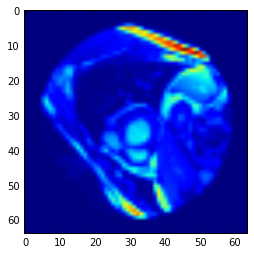

In [145]:
plt.imshow(img)

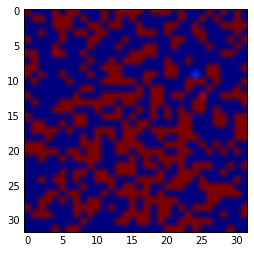

In [146]:
v = model.predict(u)
v=v.reshape((32,32))
plt.imshow(v)

In [131]:
roi_h5 = h5py.File('../data/roi_training_sub.h5','r')

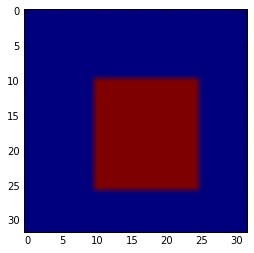

In [133]:
plt.imshow(roi_h5['X'][m])